# Pima Indians Diabetes Database

## Sources:
- Original owners: `National Institute of Diabetes and Digestive and Kidney Diseases`
- Donor of database: `Research Center, RMI Group Leader Applied Physics Laboratory, The Johns Hopkins University`
- Number of Instances: 768
- Number of Attributes: 8 plus class
- For Each Attribute: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)
- Missing Attribute Values: Yes
- Class Distribution:
  * **Positive Tested** Class value = 1
  * **Negative Tested** Class value = 0
- Class Value  Number of instances
  * Class 0: 500
  * Class 1: 268

## Import neccessary libraries


In [1]:
!pip -q install timm
!pip -q install transformers
!pip -q install evaluate
!pip -q install lion-pytorch
!pip -q install torchmetrics
!pip -q install torchsummary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 6.1 MB/s eta 0:00:00


In [2]:
from numpy import loadtxt
import numpy as np
import pandas as pd
# for the improved version, for more flexible of my design, we decide to use PyTorch framework to create a model
import torch
import torch.nn as nn
import timm
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Dict
from torchmetrics import Accuracy
from torchmetrics.classification import BinaryAccuracy
from torchsummary import summary
from sklearn.model_selection import StratifiedKFold
from lion_pytorch import Lion
import matplotlib.pyplot as plt
import glob
import os
%matplotlib inline

## Prepare data for training

In [3]:
# download diabetes datasest and its description
!wget "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
!wget "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names"

--2023-09-20 11:42:25--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23278 (23K) [text/plain]
Saving to: ‘pima-indians-diabetes.data.csv’

pima-indians-diabet 100%[===================>]  22.73K  --.-KB/s    in 0.001s  

2023-09-20 11:42:25 (16.3 MB/s) - ‘pima-indians-diabetes.data.csv’ saved [23278/23278]

--2023-09-20 11:42:25--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting

## TODO 1: Split dataset into Input (X) and Output (y)

**Score: 1%**

**Input Variables (X):**
1. Number of times pregnant
2. Plasma glucose concentration at 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)

**Output Variables (y):**
9. Class variable (0 or 1)

**Guideline:**

You can split the array into two arrays by selecting subsets of columns
using the standard NumPy slice operator or “:”.

Remember, in NumPy, the first column always started at 0

**Instruction:**

Split data into input (`X`) and output (`y`) variables, respectively. Repleace `None` to a number.

In [4]:
# check for the datashape in order to split the dataset
dataset = loadtxt('/content/pima-indians-diabetes.data.csv', delimiter=',')
print(dataset.shape)
dataset

(768, 9)


array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])

In [5]:
# load the dataset
dataset = loadtxt('/content/pima-indians-diabetes.data.csv', delimiter=',')


# **Let's Try Preprocessing**



In [6]:
df = pd.DataFrame(dataset)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       768 non-null    float64
 1   1       768 non-null    float64
 2   2       768 non-null    float64
 3   3       768 non-null    float64
 4   4       768 non-null    float64
 5   5       768 non-null    float64
 6   6       768 non-null    float64
 7   7       768 non-null    float64
 8   8       768 non-null    float64
dtypes: float64(9)
memory usage: 54.1 KB


In [8]:
df.describe()

,0,1,2,3,4,5,6,7,8
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [9]:
column_means = df.replace(0, np.nan).mean()

# Fill 0 values with means
df_filled = df.replace(0, column_means)

# Display DataFrame with missing values imputed
print(df_filled)

             0      1     2         3           4     5      6     7    8
0     6.000000  148.0  72.0  35.00000  155.548223  33.6  0.627  50.0  1.0
1     1.000000   85.0  66.0  29.00000  155.548223  26.6  0.351  31.0  1.0
2     8.000000  183.0  64.0  29.15342  155.548223  23.3  0.672  32.0  1.0
3     1.000000   89.0  66.0  23.00000   94.000000  28.1  0.167  21.0  1.0
4     4.494673  137.0  40.0  35.00000  168.000000  43.1  2.288  33.0  1.0
..         ...    ...   ...       ...         ...   ...    ...   ...  ...
763  10.000000  101.0  76.0  48.00000  180.000000  32.9  0.171  63.0  1.0
764   2.000000  122.0  70.0  27.00000  155.548223  36.8  0.340  27.0  1.0
765   5.000000  121.0  72.0  23.00000  112.000000  26.2  0.245  30.0  1.0
766   1.000000  126.0  60.0  29.15342  155.548223  30.1  0.349  47.0  1.0
767   1.000000   93.0  70.0  31.00000  155.548223  30.4  0.315  23.0  1.0

[768 rows x 9 columns]


# END

In [10]:
dataset = df.values

In [11]:
X = dataset[:, :-1]
y = dataset[:, -1]

In [12]:
# check the data shape after we made a splitm where it is in form of (rows, cols)
print(X.shape, y.shape)

(768, 8) (768,)


# Quick Visualization
- to see some distribution of the data

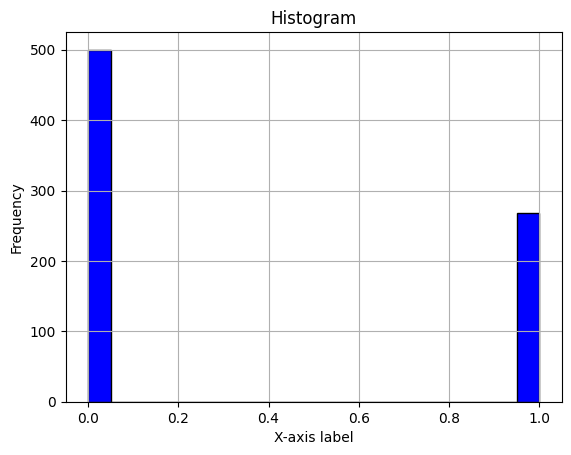

In [13]:
# make a visualization
# Plot the histogram
plt.hist(y, bins=20, color='blue', edgecolor='black')  # You can adjust the number of bins
plt.title('Histogram')
plt.xlabel('X-axis label')
plt.ylabel('Frequency')
plt.grid(True)
# Show the plot
plt.show()

In [14]:
# show that the dataset has 768 records of datqa and 8 features exluding the label itself
index = 300
print('here is a feature shape:', X.shape)
print(X[index])
print('here is a label shape:',y.shape)
print(y[index])

here is a feature shape: (768, 8)
[  0.    167.      0.      0.      0.     32.3     0.839  30.   ]
here is a label shape: (768,)
1.0


## TODO 2: Training and Testing

**Score: 1%**

**Instruction:**

Fill out `None` to split dataset into 80% and 20% for training and testing datasets, respectively.



In [15]:
train = 0.8 # since we will make a 80% split
train_b = int(np.rint(X.shape[0] * train))
print('Total records in training batch:', train_b, 'that is', (train_b/dataset.shape[0]),'%')

X_train = X[0:train_b, :]
y_train = y[0:train_b]
X_test  = X[train_b:, :]
y_test  = y[train_b:]

# check for its shape after make a train, test, split
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

Total records in training batch: 614 that is 0.7994791666666666 %
X_train shape: (614, 8)
y_train shape: (614,)
X_test shape: (154, 8)
y_test shape: (154,)


In [16]:
# check that what we split is correct
index = 300
print(X_train[index])
print(y_train[index])

[  0.    167.      0.      0.      0.     32.3     0.839  30.   ]
1.0


# Construct a new model ✅

In [17]:
# construct a custom dataset to pass it through dataloader
class pidDataset(Dataset):
  def __init__(self,
               data: np.ndarray,
               label: np.ndarray,
               required_torch: bool=True):

    self.data = data
    self.label = label
    self.required_torch = required_torch

  def __len__(self) -> int:
    return len(self.data)

  def __getitem__(self, index: int) -> Tuple:
    # index the data to be returned
    feature = np.array(self.data[index], dtype=np.float64)
    label = np.array(self.label[index], dtype=np.float64)

    if (self.required_torch):
      feature = torch.from_numpy(feature)
      label = torch.from_numpy(label)

    return feature, label


In [18]:
# Create an instance of custom PID dataset
train_dataset = pidDataset(X_train, y_train)
test_dataset = pidDataset(X_test, y_test)

# Create a DataLoader (default will be in format of torch)
batch_size = 10
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [19]:
# test for output from the dataloader
next(iter(train_dataloader))

[tensor([[  5.0000,  99.0000,  74.0000,  27.0000,   0.0000,  29.0000,   0.2030,
           32.0000],
         [  0.0000, 104.0000,  64.0000,  37.0000,  64.0000,  33.6000,   0.5100,
           22.0000],
         [  4.0000,  76.0000,  62.0000,   0.0000,   0.0000,  34.0000,   0.3910,
           25.0000],
         [  0.0000, 129.0000, 110.0000,  46.0000, 130.0000,  67.1000,   0.3190,
           26.0000],
         [  7.0000, 100.0000,   0.0000,   0.0000,   0.0000,  30.0000,   0.4840,
           32.0000],
         [  1.0000,  89.0000,  24.0000,  19.0000,  25.0000,  27.8000,   0.5590,
           21.0000],
         [  0.0000, 108.0000,  68.0000,  20.0000,   0.0000,  27.3000,   0.7870,
           32.0000],
         [ 13.0000, 145.0000,  82.0000,  19.0000, 110.0000,  22.2000,   0.2450,
           57.0000],
         [ 10.0000, 133.0000,  68.0000,   0.0000,   0.0000,  27.0000,   0.2450,
           36.0000],
         [  6.0000, 109.0000,  60.0000,  27.0000,   0.0000,  25.0000,   0.2060,
           

# Custom `FeaturizedConvolution` Network 🔥🏆


---


***Remarks:*** As of survey with some classmates until September 10th, This is the `smallest` and `fastest` model existing in the Deep Learning class right now ! 🥇


---



1.   smaller than `AutoML` ensemble model params that stacked many models in many layers (e.g. WeightEnsembleL2/L3 from AutoGluon)

2.   obtain `81.87% accuracy`✅ by containing just only `176 parameters`! which is smaller than professor model (neural network with 209params achieving 76% accuracy)

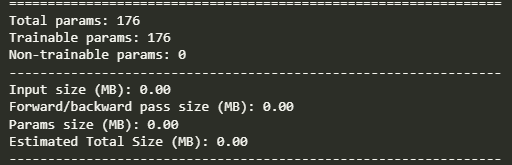

3. faster training time `(<30 seconds even when performing cross validation)` even it utilize CPU as an accelerator ⚡

4. no need for ensembling of many trees that required many increased parameters 🌳

5. achieves `competitive performance` with gradient-boosting algorithm (e.g. catboost@acc79, [best-200iterations]catboost@acc82) and reveals an interesting performance compared to another deep learning model according to its smaller model size (e.g. professorModel@acc76)  ⛹

---
- Credits: This Architecture was designed by `Mr. Pavaris Ruangchutiphophan` inspired by an idea of 1-dimensional convolution on signal data
---

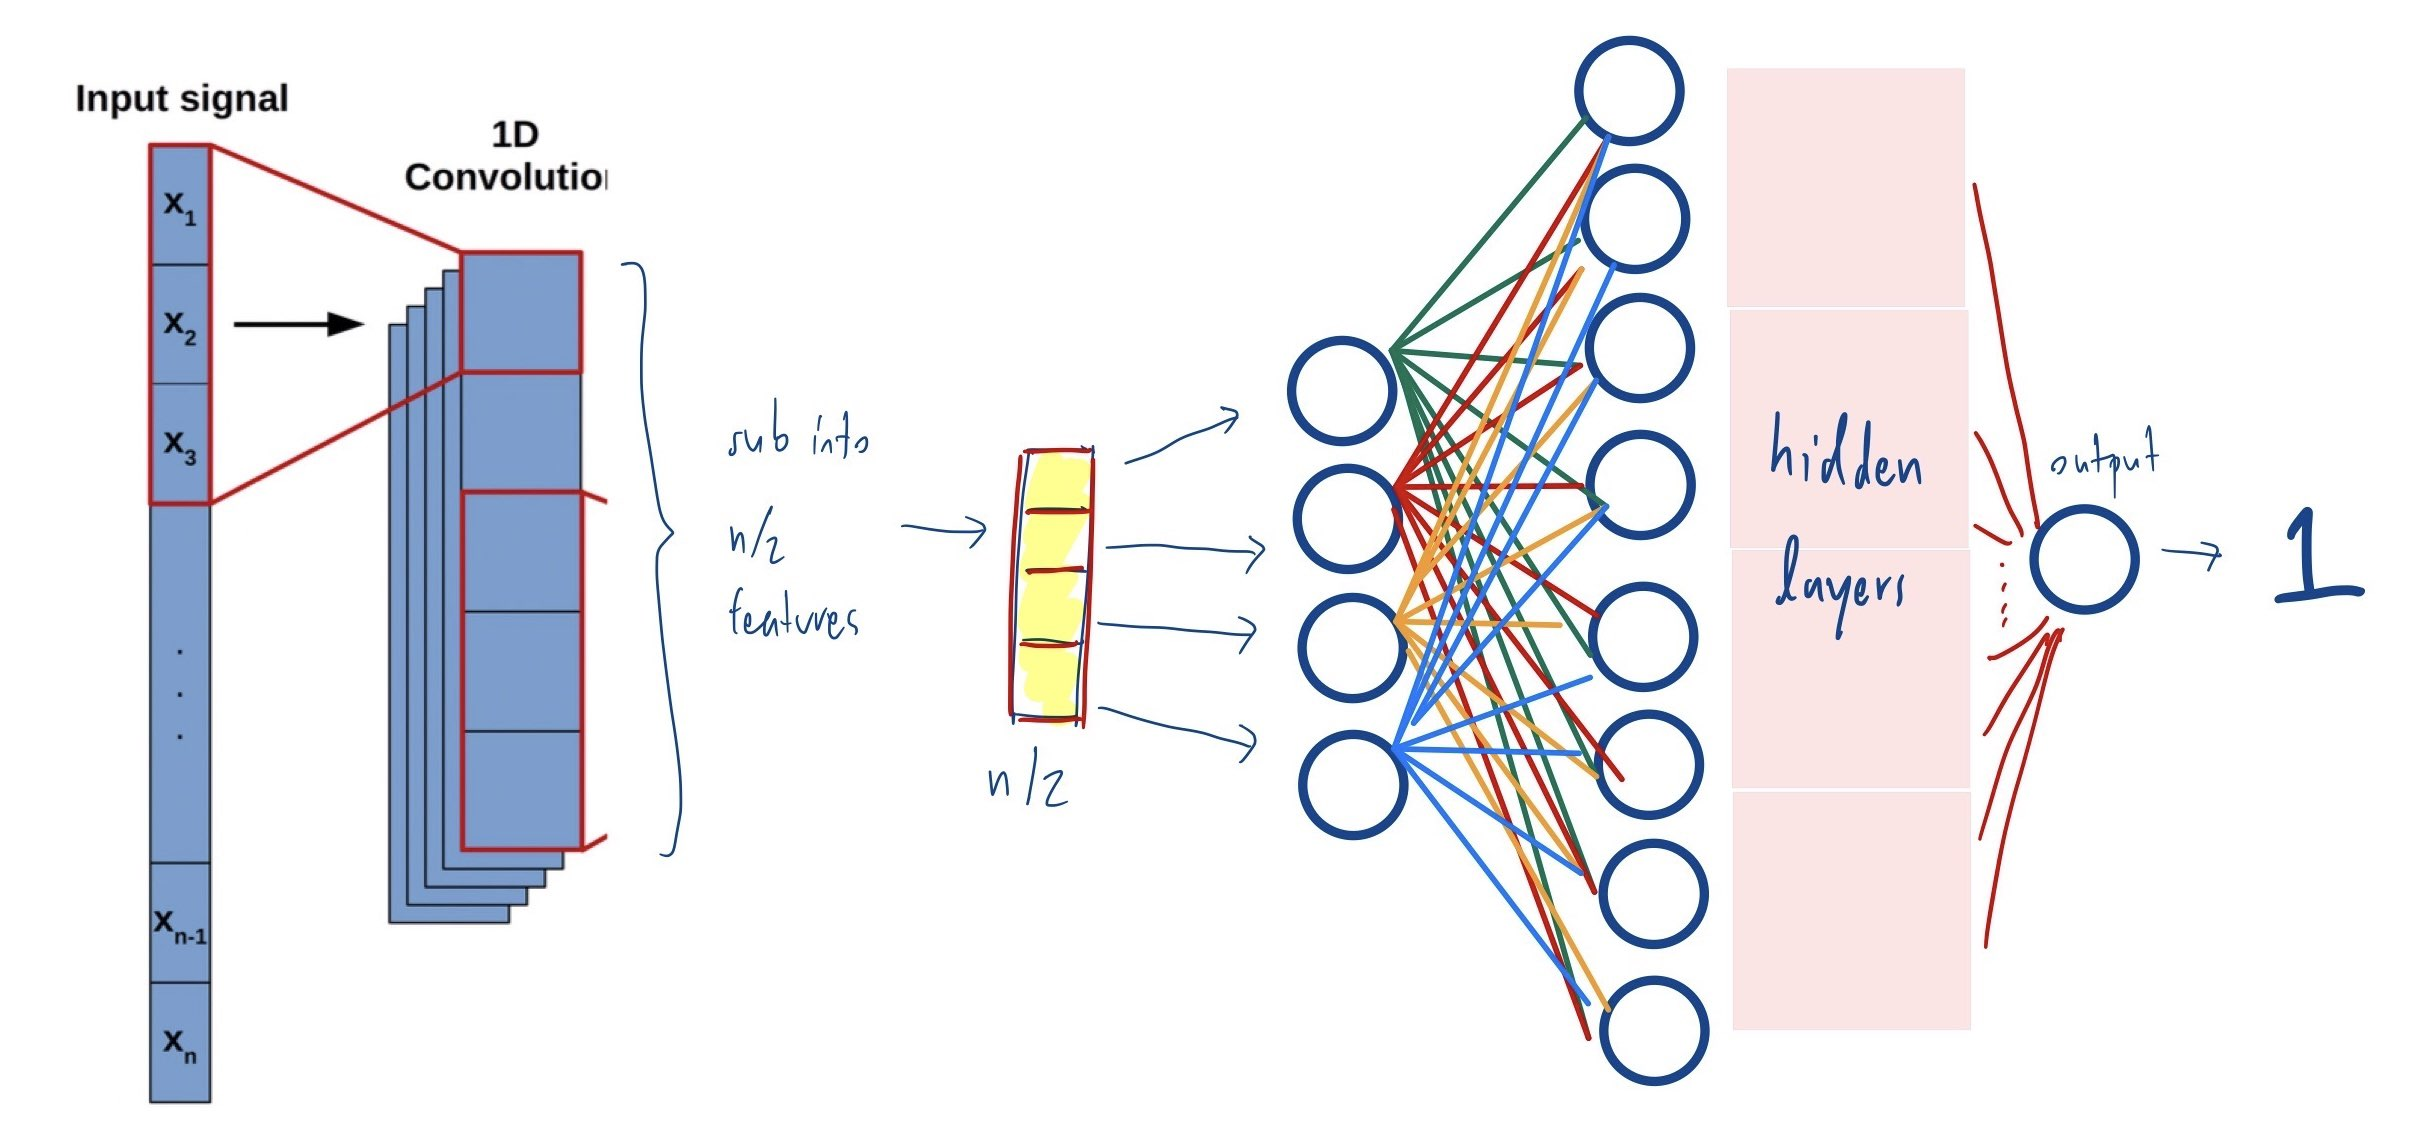

In [20]:
# write a training loop, and, optimize the model
# test for enhancement
class cnn1Dmodel(nn.Module):
  # write a initialization of the model
  def __init__(self,
               input_features: int,
               out_features: int,
               num_labels: int,
               k_size: int = 2,
               stride: int = 2
               ):

    super(cnn1Dmodel, self).__init__()
    # for featurized the input into much more interesting way
    self.conv1 = nn.Conv1d(in_channels=input_features,
                           out_channels=out_features,
                           kernel_size=k_size,
                           stride=stride,
                           )
    # this is a normal nn as we know
    self.dense1 = nn.Linear(in_features=4,
                            out_features=12,
                            bias=True)

    self.dense2 = nn.Linear(in_features=12,
                            out_features=8,
                            bias=True)

    # define ReLU for output normalization
    self.relu = nn.ReLU()
    self.output_layer = nn.Linear(in_features=8,
                                  out_features=1,
                                  bias=True)

  # this part is just for testing convolution
  def test_convolve(self, x: torch.Tensor)->torch.Tensor:
    return self.conv1(x)

  def forward(self, x: torch.Tensor)->torch.Tensor:
    # do convolution
    convolve = self.conv1(x)
    x1 = self.relu(self.dense1(convolve))
    x2 = self.relu(self.dense2(x1))
    # here is the raw logits output, we will not convert it here
    logits = self.output_layer(x2)

    return logits


In [21]:
# define a model
model1 = cnn1Dmodel(input_features=1,
               out_features=1,
               num_labels=2,
               k_size= 2,
               stride= 2)
model1

cnn1Dmodel(
  (conv1): Conv1d(1, 1, kernel_size=(2,), stride=(2,))
  (dense1): Linear(in_features=4, out_features=12, bias=True)
  (dense2): Linear(in_features=12, out_features=8, bias=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
)

In [22]:
next(iter(train_dataloader))[0].unsqueeze(1).shape

torch.Size([10, 1, 8])

In [23]:
sequence_length = 8  # Adjust the sequence length as needed
batch_size = 10
num_features = 1

# Generate random input data with the specified shape
input_data = torch.randn(batch_size, num_features, sequence_length)
print(input_data.shape)
print(model1.test_convolve(input_data).shape)
model1.test_convolve(input_data)

torch.Size([10, 1, 8])
torch.Size([10, 1, 4])


tensor([[[ 0.3325,  0.4854,  0.0592,  0.4394]],

        [[ 0.3840,  0.3445,  0.1788,  0.2877]],

        [[ 0.3237,  0.1669,  0.3621,  0.0381]],

        [[ 0.4410,  0.3919,  0.4454,  0.6359]],

        [[ 0.4489,  0.0873,  0.2432,  0.5014]],

        [[ 0.3028,  0.4838,  0.3101,  0.4391]],

        [[ 0.3487,  0.2940,  0.2444,  0.0327]],

        [[ 0.3358,  0.2796,  0.2505,  0.2914]],

        [[ 0.3993,  0.4715,  0.6084,  0.2825]],

        [[-0.0085,  0.3776,  0.2301,  0.7692]]],
       grad_fn=<ConvolutionBackward0>)

# Construct a Training loop
- keytakaways: `AdamW` converge `2x faster` than `Lion` optimizer in this case.

In [24]:
# define loss function and optimizer (Lion)
# define a model
model1 = cnn1Dmodel(input_features=1, out_features=1,num_labels=2,k_size= 2,stride= 2)
# optimizer = Lion(model1.parameters(), lr=1e-2, weight_decay=1e-2)
optimizer = torch.optim.AdamW(model1.parameters(), lr=1e-2)
metric = BinaryAccuracy()
loss_fn = nn.BCELoss()

In [25]:
epochs = 300

torch.manual_seed(69)
 # convert all the model parameters into double type.
 # This should give a compatible model given your input data is double
model1 = model1.double()
epoch_counts = []
train_loss_values = []
val_loss_values = []

best_val_acc, best_val_loss = 0, 0
for epoch in tqdm(range(epochs), desc='training the model ...'):
  ## Training
  train_acc, train_loss = 0, 0
  # Add a loop to loop trhough the training batches
  for batch, (features, labels) in enumerate(train_dataloader):
    model1.train()
    # forward pass
    # format label to make it compatible with prediction
    labels = labels.unsqueeze(-1).unsqueeze(-1)
    raw_logits = model1(features.unsqueeze(1))
    #print(raw_logits)
    probs = torch.sigmoid(raw_logits)
    preds = (probs > 0.5).float()
    # since bceLoss take probability as an input (not logits)
    loss = loss_fn(probs, labels)
    acc = metric(preds, labels)
    # save stats
    train_loss += loss
    train_acc += acc

    # optimizer zero grad
    optimizer.zero_grad()
    # compute backward loss (backpropagation)
    loss.backward()
    # Gradient Descent (optimizer step)
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  # evaluation loop
  val_acc, val_loss = 0, 0
  for batch, (val_features, val_labels) in enumerate(test_dataloader):
    with torch.inference_mode():
      # make it compare to prediction
      val_labels = val_labels.unsqueeze(-1).unsqueeze(-1)
      val_logits = model1(val_features.unsqueeze(1))
      val_probs = torch.sigmoid(val_logits)
      val_preds = (val_probs > 0.5).float()
      loss = loss_fn(val_probs, val_labels)
      acc = metric(val_preds, val_labels)
      # update stats
      val_loss += loss
      val_acc += acc

  val_loss = val_loss / len(test_dataloader)
  val_acc  = val_acc / len(test_dataloader)

  if (val_acc > best_val_acc):
    print(f"Best Model @ epoch : {epoch}")
    print(f"Train loss: {train_loss:.4f} | val loss : {val_loss:.4f} | train acc: {train_acc:.4f} | val acc: {val_acc:.4f}")
    best_val_acc = val_acc
    torch.save(model1.state_dict(), f'/content/custom_model/best_model_1.pth')


training the model ...:   0%|          | 0/300 [00:00<?, ?it/s]

Best Model @ epoch : 0
Train loss: 0.7324 | val loss : 0.6443 | train acc: 0.6258 | val acc: 0.6469
Best Model @ epoch : 2
Train loss: 0.6202 | val loss : 0.6376 | train acc: 0.6556 | val acc: 0.6531
Best Model @ epoch : 4
Train loss: 0.5954 | val loss : 0.5965 | train acc: 0.6992 | val acc: 0.6781
Best Model @ epoch : 7
Train loss: 0.5928 | val loss : 0.5891 | train acc: 0.6879 | val acc: 0.6969
Best Model @ epoch : 9
Train loss: 0.5701 | val loss : 0.5830 | train acc: 0.7234 | val acc: 0.7219
Best Model @ epoch : 13
Train loss: 0.5627 | val loss : 0.5757 | train acc: 0.7097 | val acc: 0.7406
Best Model @ epoch : 14
Train loss: 0.5570 | val loss : 0.5625 | train acc: 0.7202 | val acc: 0.7469
Best Model @ epoch : 29
Train loss: 0.5365 | val loss : 0.5248 | train acc: 0.7226 | val acc: 0.7656
Best Model @ epoch : 50
Train loss: 0.5117 | val loss : 0.5243 | train acc: 0.7476 | val acc: 0.7875
Best Model @ epoch : 66
Train loss: 0.4873 | val loss : 0.5206 | train acc: 0.7694 | val acc: 0.

In [26]:
# Print the model summary, including the number of parameters and memory usage
summary(model1.to(torch.float), (1, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                 [-1, 1, 4]               3
            Linear-2                [-1, 1, 12]              60
              ReLU-3                [-1, 1, 12]               0
            Linear-4                 [-1, 1, 8]             104
              ReLU-5                 [-1, 1, 8]               0
            Linear-6                 [-1, 1, 1]               9
Total params: 176
Trainable params: 176
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Psuedo Labelling Part

In [27]:
# Load the saved state dictionary of the best model (acc: 0.81) into the model
psuedo_model = cnn1Dmodel(input_features=1, out_features=1,num_labels=2,k_size= 2,stride= 2)
psuedo_model.load_state_dict(torch.load('/content/custom_model/best_model_1.pth'))
psuedo_model

cnn1Dmodel(
  (conv1): Conv1d(1, 1, kernel_size=(2,), stride=(2,))
  (dense1): Linear(in_features=4, out_features=12, bias=True)
  (dense2): Linear(in_features=12, out_features=8, bias=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
)

In [28]:
# create a dataloader for specific pseudo labelling part
pseudo_dataloader = DataLoader(test_dataset, batch_size=1) # consider each of them instead of batch

In [29]:
# make a psuedo label
conf = [] # to keep the pseudo labels

# convert the model into double format
psuedo_model = psuedo_model.double()
for index, (feature, label) in enumerate(pseudo_dataloader):
  with torch.inference_mode():
    label = label.unsqueeze(-1).unsqueeze(-1)
    logit = psuedo_model(feature.unsqueeze(1))
    prob = torch.sigmoid(logit)
    # get condition part
    if (prob > 0.85):
      conf.append(index)
    elif (prob <= 0.3):
      conf.append(index)

print(conf)
print(len(conf))

[3, 7, 8, 9, 10, 11, 15, 17, 19, 20, 23, 24, 25, 26, 29, 30, 35, 36, 37, 40, 41, 42, 45, 51, 57, 58, 59, 60, 61, 63, 65, 66, 68, 70, 78, 80, 83, 88, 90, 91, 92, 93, 94, 95, 96, 99, 103, 104, 105, 106, 107, 115, 119, 120, 121, 122, 123, 124, 127, 128, 133, 138, 144, 146, 147, 148, 153]
67


In [30]:
# indexing psuedo label
psuedo_feature = []
psuedo_label = []
for id in conf:
  psuedo_feature.append(X_test[int(id)])
  psuedo_label.append(y_test[int(id)])

In [31]:
# Concatenate the arrays vertically
train_features = np.vstack((X_train, psuedo_feature))
train_labels = np.hstack((y_train, psuedo_label))

In [32]:
print("Before Psuedo Labelling")
print(X_train.shape)
print(y_train.shape)
print("After Psuedo Labelling")
print(train_features.shape)
print(train_labels.shape)

Before Psuedo Labelling
(614, 8)
(614,)
After Psuedo Labelling
(681, 8)
(681,)


# Train the model with `psuedo label`

In [33]:
# Create an instance of custom PID dataset
p_train_dataset = pidDataset(train_features, train_labels)

# Create a DataLoader (default will be in format of torch)
batch_size = 10
p_train_dataloader = DataLoader(p_train_dataset, batch_size=batch_size, shuffle=True)

In [34]:
len(p_train_dataloader)

69

In [35]:
# define a model
new_model = cnn1Dmodel(input_features=1, out_features=1,num_labels=2,k_size= 2,stride= 2)
optimizer = torch.optim.AdamW(new_model.parameters(), lr=1e-2)

In [36]:
epochs = 300

torch.manual_seed(69)
 # convert all the model parameters into double type.
 # This should give a compatible model given your input data is double
new_model = new_model.double()

epoch_counts = []
train_loss_values = []
val_loss_values = []

best_val_acc, best_val_loss = 0, 0
for epoch in tqdm(range(epochs), desc='training the model ...'):
  ## Training
  train_acc, train_loss = 0, 0
  # Add a loop to loop trhough the training batches
  for batch, (features, labels) in enumerate(p_train_dataloader):
    new_model.train()
    # forward pass
    # format label to make it compatible with prediction
    labels = labels.unsqueeze(-1).unsqueeze(-1)
    raw_logits = new_model(features.unsqueeze(1))
    #print(raw_logits)
    probs = torch.sigmoid(raw_logits)
    preds = (probs > 0.5).float()
    # since bceLoss take probability as an input (not logits)
    loss = loss_fn(probs, labels)
    acc = metric(preds, labels)
    # save stats
    train_loss += loss
    train_acc += acc

    # optimizer zero grad
    optimizer.zero_grad()
    # compute backward loss (backpropagation)
    loss.backward()
    # Gradient Descent (optimizer step)
    optimizer.step()

  train_loss /= len(p_train_dataloader)
  train_acc /= len(p_train_dataloader)

  # evaluation loop
  val_acc, val_loss = 0, 0
  for batch, (val_features, val_labels) in enumerate(test_dataloader):
    with torch.inference_mode():
      # make it compare to prediction
      val_labels = val_labels.unsqueeze(-1).unsqueeze(-1)
      val_logits = new_model(val_features.unsqueeze(1))
      val_probs = torch.sigmoid(val_logits)
      val_preds = (val_probs > 0.5).float()
      loss = loss_fn(val_probs, val_labels)
      acc = metric(val_preds, val_labels)
      # update stats
      val_loss += loss
      val_acc += acc

  val_loss = val_loss / len(test_dataloader)
  val_acc  = val_acc / len(test_dataloader)

  if (val_acc > best_val_acc):
    print(f"Best Model @ epoch : {epoch}")
    print(f"Train loss: {train_loss:.4f} | val loss : {val_loss:.4f} | train acc: {train_acc:.4f} | val acc: {val_acc:.4f}")
    best_val_acc = val_acc
    torch.save(new_model.state_dict(), f'/content/custom_model/best_model_4.pth')



training the model ...:   0%|          | 0/300 [00:00<?, ?it/s]

Best Model @ epoch : 0
Train loss: 0.7271 | val loss : 0.6939 | train acc: 0.6580 | val acc: 0.6469
Best Model @ epoch : 4
Train loss: 0.6152 | val loss : 0.6279 | train acc: 0.6783 | val acc: 0.6781
Best Model @ epoch : 8
Train loss: 0.5984 | val loss : 0.6189 | train acc: 0.6812 | val acc: 0.6781
Best Model @ epoch : 19
Train loss: 0.5660 | val loss : 0.5809 | train acc: 0.7029 | val acc: 0.7031
Best Model @ epoch : 28
Train loss: 0.5179 | val loss : 0.5744 | train acc: 0.7217 | val acc: 0.7031
Best Model @ epoch : 29
Train loss: 0.5204 | val loss : 0.5303 | train acc: 0.7261 | val acc: 0.7094
Best Model @ epoch : 30
Train loss: 0.5186 | val loss : 0.5307 | train acc: 0.7290 | val acc: 0.7781
Best Model @ epoch : 51
Train loss: 0.5075 | val loss : 0.4995 | train acc: 0.7522 | val acc: 0.7781
Best Model @ epoch : 55
Train loss: 0.4954 | val loss : 0.5117 | train acc: 0.7681 | val acc: 0.7844
Best Model @ epoch : 60
Train loss: 0.4598 | val loss : 0.4712 | train acc: 0.7754 | val acc: 

#Ensemble Method of `FeaturizedCNN` ⚡
- each fold will be divided by `StratifiedKFold` where `K=5`



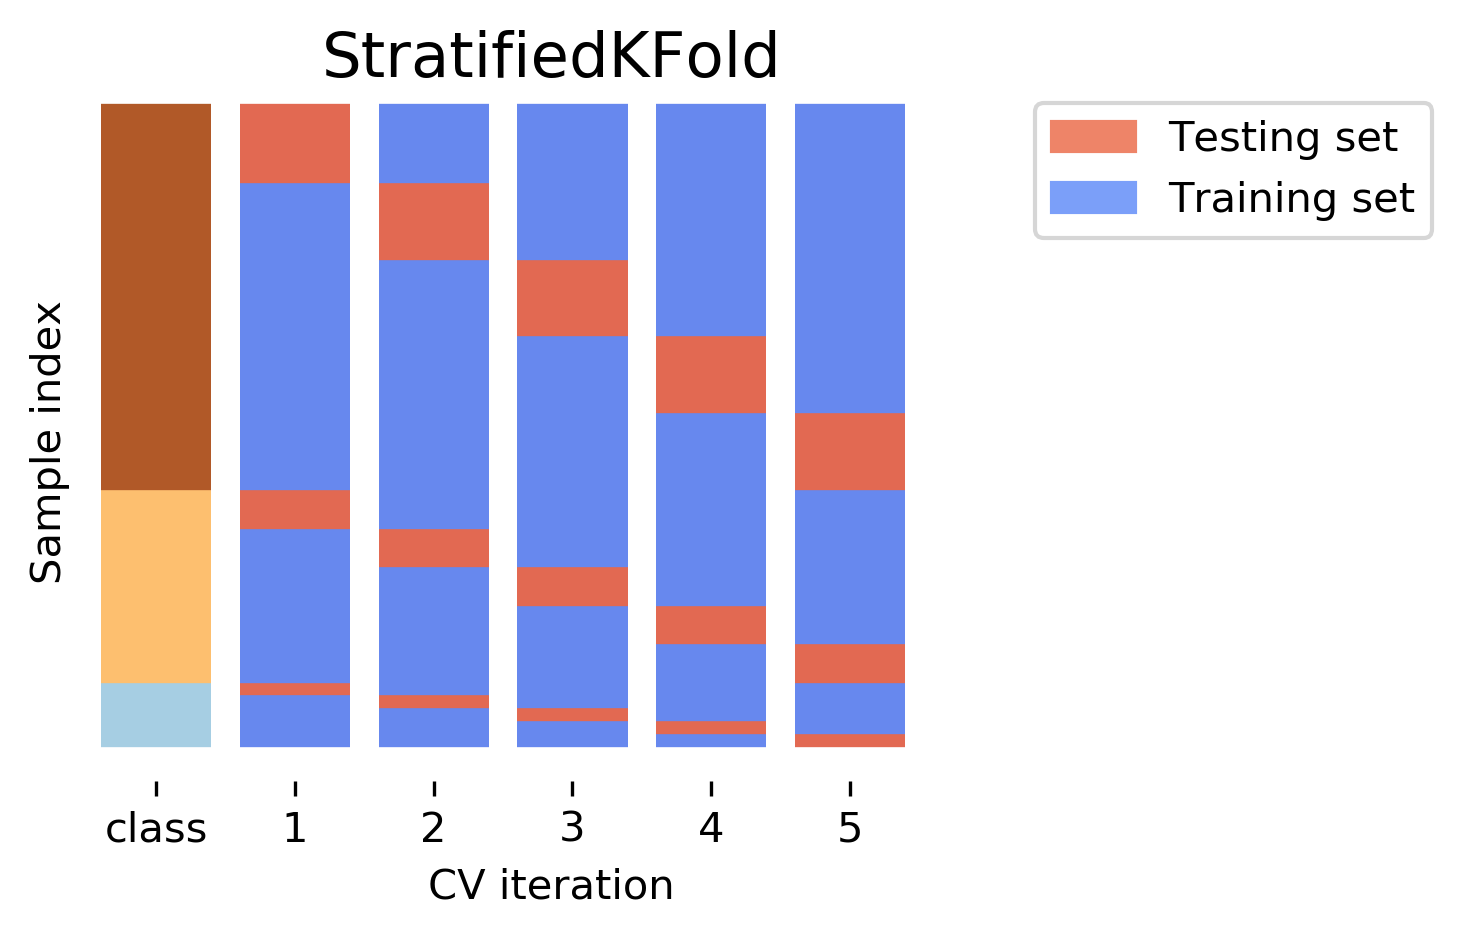

In [37]:
# get the shape of initial model
X.shape, y.shape

((768, 8), (768,))

In [38]:
# init for stratified K-fold
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)

5

In [39]:
# check for their split of StratifiedKFold (K-Fold)
batch_size = 10
epochs = 300

# set the seed for reproducibility
torch.manual_seed(69)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
  X_train, y_train = X[train_index], y[train_index]
  X_test, y_test = X[test_index], y[test_index]
  # print(X_train.shape, y_train.shape)
  # print(X_test.shape, y_test.shape)

  # Create an instance of custom PID dataset
  train_dataset = pidDataset(X_train, y_train)
  test_dataset = pidDataset(X_test, y_test)

  # Create a DataLoader (default will be in format of torch)
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

  # define a model (with k-fold, we always re-initialize the model)
  model = cnn1Dmodel(input_features=1, out_features=1,num_labels=2,k_size= 2,stride= 2)
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
  metric = BinaryAccuracy()
  loss_fn = nn.BCELoss()

  # construct a training loop
  # convert all the model parameters into double type.
  # This should give a compatible model given your input data is double
  model = model.double()

  epoch_counts = []
  train_loss_values = []
  val_loss_values = []

  # to keep record of the best model (my epoch start counting from zero)
  best_epoch, best_train_acc, best_train_loss = 0, 0, 0
  best_val_acc, best_val_loss = 0, 0

  for epoch in tqdm(range(epochs), desc=f'training the model at fold{fold+1}'):
    ## Training
    train_acc, train_loss = 0, 0
    # Add a loop to loop trhough the training batches
    for batch, (features, labels) in enumerate(train_dataloader):
      model.train()
      # forward pass
      # format label to make it compatible with prediction
      labels = labels.unsqueeze(-1).unsqueeze(-1)
      raw_logits = model(features.unsqueeze(1))
      probs = torch.sigmoid(raw_logits)
      preds = (probs > 0.5).float()
      # since bceLoss take probability as an input (not logits)
      loss = loss_fn(probs, labels)
      acc = metric(preds, labels)
      # save stats
      train_loss += loss
      train_acc += acc

      # optimizer zero grad
      optimizer.zero_grad()
      # compute backward loss (backpropagation)
      loss.backward()
      # Gradient Descent (optimizer step)
      optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # evaluation loop
    val_acc, val_loss = 0, 0
    for batch, (val_features, val_labels) in enumerate(test_dataloader):
      with torch.inference_mode():
        # make it compare to prediction
        val_labels = val_labels.unsqueeze(-1).unsqueeze(-1)
        val_logits = model(val_features.unsqueeze(1))
        val_probs = torch.sigmoid(val_logits)
        val_preds = (val_probs > 0.5).float()
        loss = loss_fn(val_probs, val_labels)
        acc = metric(val_preds, val_labels)
        # update stats
        val_loss += loss
        val_acc += acc

    val_loss = val_loss / len(test_dataloader)
    val_acc  = val_acc / len(test_dataloader)

    if (val_acc > best_val_acc):
      # record the stats of the best model
      best_val_acc = val_acc # this should be update for finding the best model
      best_val_loss = val_loss
      best_train_acc = train_acc
      best_train_loss = train_loss
      best_epoch = epoch
      torch.save(model.state_dict(), f'/content/ensemble/best_model_fold{fold+1}.pth')

  print(f"--- Fold{fold+1} ---")
  print(f"Best Model @ epoch : {best_epoch}")
  print(f"Train loss: {best_train_loss:.4f} | val loss : {best_val_loss:.4f} | train acc: {best_train_acc:.4f} | val acc: {best_val_acc:.4f}")

  # uncomment this part to visualize each fold
  #break

training the model at fold1:   0%|          | 0/300 [00:00<?, ?it/s]

--- Fold1 ---
Best Model @ epoch : 193
Train loss: 0.4918 | val loss : 0.5211 | train acc: 0.7556 | val acc: 0.7875


training the model at fold2:   0%|          | 0/300 [00:00<?, ?it/s]

--- Fold2 ---
Best Model @ epoch : 211
Train loss: 0.4667 | val loss : 0.5322 | train acc: 0.7750 | val acc: 0.7594


training the model at fold3:   0%|          | 0/300 [00:00<?, ?it/s]

--- Fold3 ---
Best Model @ epoch : 53
Train loss: 0.5125 | val loss : 0.4530 | train acc: 0.7540 | val acc: 0.8000


training the model at fold4:   0%|          | 0/300 [00:00<?, ?it/s]

--- Fold4 ---
Best Model @ epoch : 101
Train loss: 0.4981 | val loss : 0.4578 | train acc: 0.7452 | val acc: 0.8167


training the model at fold5:   0%|          | 0/300 [00:00<?, ?it/s]

--- Fold5 ---
Best Model @ epoch : 56
Train loss: 0.4916 | val loss : 0.4895 | train acc: 0.7742 | val acc: 0.8062


# Voting Ensemble (Fundamental) ⛪
- since the model in fold 5 is the strongest model, then, an inference will keep respect to that model

In [40]:
def esb_evaluate(path:str):
  # Load the saved state dictionary of the best model (acc: 0.81) into the model
  model = cnn1Dmodel(input_features=1, out_features=1,num_labels=2,k_size= 2,stride= 2)
  model.load_state_dict(torch.load(path))

  prediction = [] # to keep the pseudo labels
  label_list = y_test.tolist()
  test_dataloader = DataLoader(test_dataset, batch_size=1)

  # convert the model into double format
  model = model.double()
  for index, (feature, label) in enumerate(test_dataloader):
    with torch.inference_mode():
      label = label.unsqueeze(-1).unsqueeze(-1)
      logit = model(feature.unsqueeze(1))
      prob = torch.sigmoid(logit)
      # get condition part
      if (prob > 0.5):
        prediction.append(1)
      else:
        prediction.append(0)

  check = [1 if (int(prediction[i]) == int(label_list[i])) else 0 for i in range(len(prediction))]
  score = sum(check) / len(prediction)
  return prediction


In [41]:
# make a vote ensemble on 5 models from each fold
prediction = {}
weak_models = [wmi for wmi in glob.glob('/content/ensemble/*')]
for i in range(len(weak_models)):
  prediction[f'weak_model{i}'] = esb_evaluate(weak_models[i])

In [42]:
# get a dataframe
total_prediction = pd.DataFrame(prediction)
total_prediction.head(3)

,weak_model0,weak_model1,weak_model2,weak_model3,weak_model4
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0


In [43]:
total_prediction['ensemble_predictions'] = total_prediction.mode(axis=1)
total_prediction.tail(5)

,weak_model0,weak_model1,weak_model2,weak_model3,weak_model4,ensemble_predictions
148,0,0,0,1,0,0
149,0,0,0,1,0,0
150,0,0,0,0,0,0
151,0,0,1,1,0,0
152,0,0,0,0,0,0


In [44]:
esb_preds = list(total_prediction['ensemble_predictions'])
print(len(esb_preds))

153


In [45]:
# evaluate
label_list = y_test.tolist()
check = [1 if (int(esb_preds [i]) == int(label_list[i])) else 0 for i in range(len(esb_preds))]
score = sum(check) / len(esb_preds )
print('Accuracy:', score)

Accuracy: 0.8104575163398693


# Model Soup Implementation (1 Jul 2022) 🥪
- Top3 `state-of-the-art` implementation that did not increase the time complexity and can be used to improve an accuracy

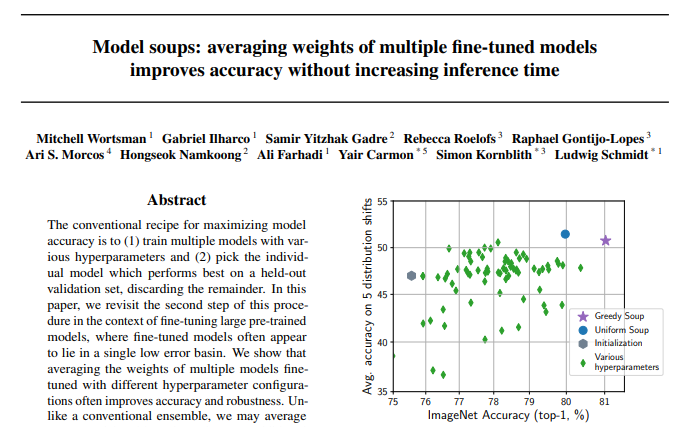

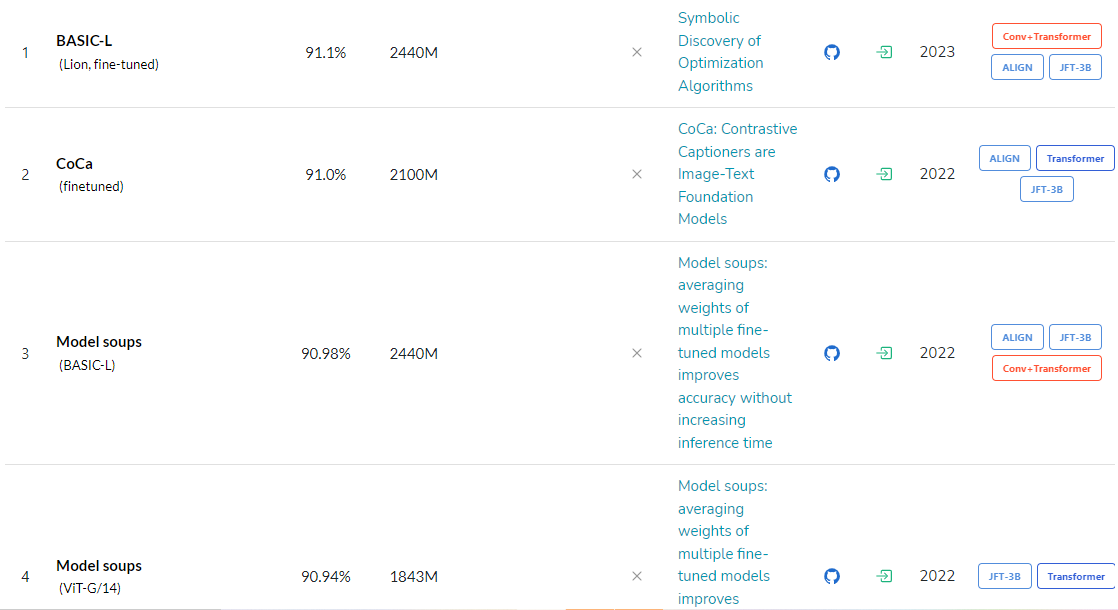

In [101]:
def evaluate(path:str):
  # Load the saved state dictionary of the best model (acc: 0.81) into the model
  model = cnn1Dmodel(input_features=1, out_features=1,num_labels=2,k_size= 2,stride= 2)
  model.load_state_dict(torch.load(path))

  prediction = [] # to keep the pseudo labels
  label_list = y_test.tolist()
  test_dataloader = DataLoader(test_dataset, batch_size=1)

  # convert the model into double format
  model = model.double()
  for index, (feature, label) in enumerate(test_dataloader):
    with torch.inference_mode():
      label = label.unsqueeze(-1).unsqueeze(-1)
      logit = model(feature.unsqueeze(1))
      prob = torch.sigmoid(logit)
      # get condition part
      if (prob > 0.5):
        prediction.append(1)
      else:
        prediction.append(0)

  check = [1 if (int(prediction[i]) == int(label_list[i])) else 0 for i in range(len(prediction))]
  score = sum(check) / len(prediction)
  return prediction, score


In [102]:
def test(test_model:nn.Module)->float:
  prediction = [] # to keep the pseudo labels
  label_list = y_test.tolist()
  test_dataloader = DataLoader(test_dataset, batch_size=1)

  # convert the model into double format
  test_model = test_model.double()
  for index, (feature, label) in enumerate(test_dataloader):
    with torch.inference_mode():
      label = label.unsqueeze(-1).unsqueeze(-1)
      logit = test_model(feature.unsqueeze(1))
      prob = torch.sigmoid(logit)
      # get condition part
      if (prob > 0.5):
        prediction.append(1)
      else:
        prediction.append(0)

  check = [1 if (int(prediction[i]) == int(label_list[i])) else 0 for i in range(len(prediction))]
  score = sum(check) / len(prediction)
  return score

In [103]:
# check for weight file
for weight in glob.glob('/content/ensemble/*'):
  print(weight)

/content/ensemble/best_model_fold3.pth
/content/ensemble/best_model_fold2.pth
/content/ensemble/best_model_fold4.pth
/content/ensemble/best_model_fold5.pth
/content/ensemble/best_model_fold1.pth


In [104]:
# set components for model soup
device = 'cuda' if torch.cuda.is_available() else 'cpu'

state_dicts = [] # list containing model weight
for weight_file in glob.glob('/content/ensemble/*'):
  state_dicts.append(torch.load(weight_file, map_location=device))


In [105]:
def get_model(state_dicts, alphal):
  model = cnn1Dmodel(input_features=1, out_features=1,num_labels=2,k_size= 2,stride= 2)
  sd = {k : state_dicts[0][k].clone() * alphal[0] for k in state_dicts[0].keys()}
  for i in range(1, len(state_dicts)):
      for k in state_dicts[i].keys():
          sd[k] = sd[k] + state_dicts[i][k].clone() * alphal[i]
  model.load_state_dict(sd)
  model = model.to(device)
  return model

In [106]:
# get validation result
val_results = []
for weight_file in glob.glob('/content/ensemble/*'):
  val_results.append(evaluate(weight_file))

In [107]:
val_results2 = []
for i in range(len(val_results)):
  val_results2.append(val_results[i][1])

In [108]:
val_results2

[0.7908496732026143,
 0.7647058823529411,
 0.7712418300653595,
 0.7973856209150327,
 0.7712418300653595]

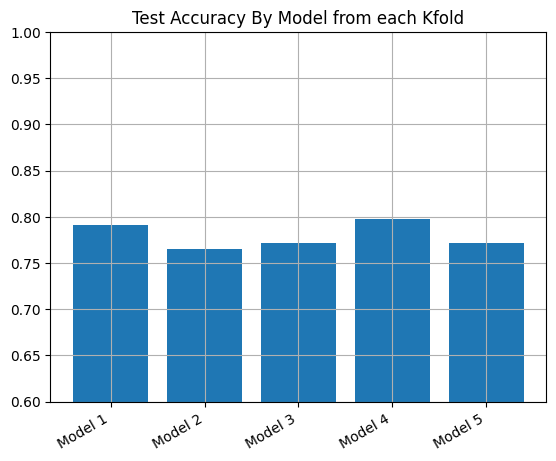

In [109]:
names = [f'Model {i+1}' for i in range(len(state_dicts))]
plt.bar(names, val_results2)
plt.title("Test Accuracy By Model from each Kfold")
plt.ylim([0.6,1])
plt.xticks(rotation=30, ha='right')
plt.grid(True)
plt.show()


# Greedy Soup ⚓

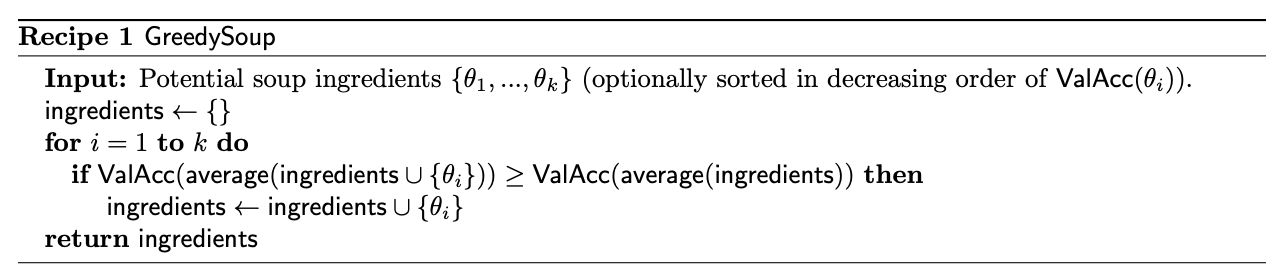

In [110]:
ranked_candidates = [i for i in range(len(state_dicts))]
ranked_candidates.sort(key=lambda x: -val_results[x][1])
current_best = val_results[ranked_candidates[0]][1]
best_ingredients = ranked_candidates[:1]
for i in range(1, len(state_dicts)):
  # add current index to the ingredients
  ingredient_indices = best_ingredients + [ranked_candidates[i]]
  alphal = [0 for i in range(len(state_dicts))]
  for j in ingredient_indices:
    alphal[j] = 1 / len(ingredient_indices)

  # benchmark and conditionally append
  model = get_model(state_dicts, alphal)
  current = test(model)
  print(f'Models {ingredient_indices} got {current*100}% on validation.')
  if current > current_best:
    current_best = current
    best_ingredients = ingredient_indices

Models [3, 0] got 65.359477124183% on validation.
Models [3, 2] got 64.05228758169935% on validation.
Models [3, 4] got 65.359477124183% on validation.
Models [3, 1] got 65.359477124183% on validation.


In [111]:
# implementation of model soup
alphal = [0 for i in range(len(state_dicts))]
for j in best_ingredients:
  alphal[j] = 1 / len(best_ingredients)
model = get_model(state_dicts, alphal)

val_results.append(test(model))
val_results2.append(test(model))
# for i in range(len(val_results)):
#   print(val_results[i][1])
print(val_results2)

[0.7908496732026143, 0.7647058823529411, 0.7712418300653595, 0.7973856209150327, 0.7712418300653595, 0.7973856209150327]


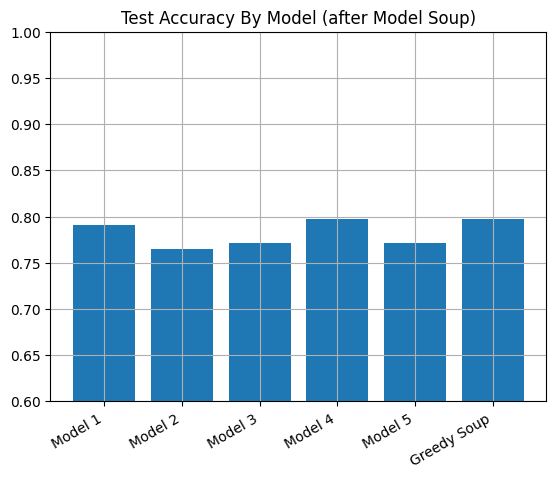

In [112]:
names.append("Greedy Soup")
plt.bar(names, val_results2)
plt.title("Test Accuracy By Model (after Model Soup)")
plt.ylim([0.6,1])
plt.xticks(rotation=30, ha='right')
plt.grid(True)
plt.show()